In [133]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import scipy.integrate as I
import astropy.units as u

Read in and process dataset for photon flux.

In [197]:
dir = pd.read_csv('./Blackhawk/results/test/photon_primary_spectrum.txt', sep = '\s+', skiprows=1)
frag = pd.read_csv('./BlackHawk/results/test/photon_secondary_spectrum.txt', sep = '\s+', skiprows=1)
dir = dir.set_index('time/energy')
frag = frag.set_index('time/energy')

# Stefano's dataset
hardness = pd.read_csv('./Blackhawk/t90_hardness_ratio/hardnessratios.tex', sep='\t')
hardness.columns

Index(['Time to Death', 'Mass', 'GBM NaI', 'GBMBGO', 'EdndE-8keV',
       'EdndE-200keV', 'EdndE-1MeV', 'EdndE-40MeV', 'EdndE-200GeV',
       'Unnamed: 9'],
      dtype='object')

In [210]:
# 20MeV to 100GeV
LAT_energy = (20 * 1e-3, 300)
# 200keV to 40MeV
GBM_energy = (200 * 1e-6, 40 * 1e-3)
# 8keV to 10eV
BGO_energy = (8 * 1e-6, 1 * 1e-3)

telescope_energy_dict = {
    'LAT_energy': LAT_energy,

    'GBM_energy': GBM_energy, # Redundancy
    'NaI_energy': GBM_energy,

    'BGO_energy': BGO_energy,

    # 50 GeV to 50 TeV
    'VERITAS_energy': (50, 50*1e3), # 2x1e-13 TeV cm^-2 s^-1

    # 100 GeV to 50 TeV (figure says 1e5 GeV so why not)
    'HAWC_energy': (100, 1e5),

    # 30 to 100 TeV
    'MAGIC_energy': (30*1e3, 1e5), # 1e-12 erg cm^-2 s^-1

    # 1e12 to 1e18 eV
    'LHAASO_energy': (1e3, 1e9), #2e-14 erg cm^-2 s^-1
}


time = hardness['Time to Death']

In [213]:
frag.columns[-10:]

Index(['1.00000e+04', '1.29155e+04', '1.66810e+04', '2.15443e+04',
       '2.78256e+04', '3.59381e+04', '4.64159e+04', '5.99484e+04',
       '7.74264e+04', '1.00000e+05'],
      dtype='object')

#### Lightcurves

Two approaches here:
- Integrate wrt to energy spectrum to get the lightcurves below for each of the energy ranges.
- Get the SED lightcurve through $EdndE$.

In [136]:
###
# Integrated lightcurve ranges approach
###

def SEDIntegrate(spectrum, multiply_power = True, verbose = False):
    r"""

    SEDIntegrate inputs 
        spectrum: `\frac{d^2n}{dtdE}` in units (/time /energy /comoving volume)=[/s /GeV /cm^3]
        multiply_power:bool : whether to multiple E at each timestep to produce power instead of flux
    Reimann integrates along ENERGY, multiplying the ENERGY BIN along every sum
    Returns `\sum_j^E`
    """
    # Tally up for each time index
    time_dependent_emission = []
    for i in range(spectrum.shape[0]):
        
        # Pick out the instantaneous energy spectrum
        inst_Espectrum = spectrum.iloc[i].to_list()

        # Assume that this range has already been constrained by the previous section
        energy_bins = spectrum.columns.astype('float');

        cumulative_sum = 0
        # Integrate over energy bins
        for j in range(energy_bins.shape[0] - 2):

            # Dimensions
            dy = np.abs(inst_Espectrum[j + 1] - inst_Espectrum[j])
            dE = np.abs( energy_bins[j + 1] - energy_bins[j] )

            # Average the additional val to multiply against
            if multiply_power: Eavg = np.abs( energy_bins[j+1] + energy_bins[j] ) / 2

            # Calculate area
            area = dE * dy # Square
            area += 0.5 * dE * dy # Triangle

            # Multiply average val
            if multiply_power: area *= Eavg

            # Sum up to cumulative integral
            cumulative_sum += area

        # Deliver result to array
        time_dependent_emission.append(cumulative_sum)
    
    # Return final energy-integrated value
    return np.array(time_dependent_emission) # In GeV /s/cm^3


# This function exists only because the time interval contains a bunch of duplicates with different y-values
# If time has values x1=x2 with different values y1!=y2, this function simply looks for the nearest x3!=x1 and 
#   computes the trapezoidal area from x1 to x3

def Riemann_Integrate(x, y, threshold = np.infty, verbose = False):
    """
    Reimann Integration returning trapezoidal integration so long as cumulative sum < threshold
    Input real-valued x-,y-data as np.array
    Returns integrated value & index at which threshold was met (default infinity)

    NOTABLY: Skips over repeated x-data by taking the lowest y of repeated indices x and 
        matching it to the next non-repeating index x

    Eventually I could also calculate this as a left- and right-hand Riemann sum and be able to show an upper- 
        and lower-bound for the T90 integration. 
    But I don't really think this would be a big differencee, since it's scaled by 1e7 already.
    """

    cum_int = 0.
    i = 0
    while i != x.shape[0] - 1: # Ends when x[i+j]

        # First, check for next repeated index
        j = 1
        while x[i] == x[i+j]: # Ends when next index x[i + j] != x[i]
            j+=1
            if i+j >= x.shape[0] - 1:
                if verbose: print('End of array exceeded.')
                break # If end up getting to the end of the array
        

        # Dimensions
        dy = y[i + j] - y[i]
        dx = np.abs( x[i + j] - x[i] )

        # Calculate area
        area = dx * dy # Square
        area += 0.5 * dx * dy # Triangle

        # Sum up to cumulative integral
        cum_int += area

        if verbose:
            print('Index %s to %s: dx = x[i+j] %s - x[i] %s and dy = y[i+j] %s - y[i] %s to running total %s'%
                (i, j, x[i+j], x[i], y[i+j], y[i], cum_int))

        # Update index
        i += j

        if threshold <= cum_int:
            # Break if sum meets threshold
            return cum_int, i

    # Return cumulative sum the index stopped on
    return cum_int, i

def generate_lightcurve(dir, frag, energy_range, LAT=True):
    """
    Integrate time-series in energy through energy_range:tuple for dir, frag. Return sum.

    For LAT, it will be power to match up with diff. flux sens erg/cm2/s: \int E d^2N/dEdt dE = E dN/dt

    For GBM, it will be flux to match up with >0.7 phot/cm2/s: \int d^2N/dEdt dE = dN/dt 
    """

    # Closest indices to given energy-range
    slice_dir = dir.copy()
    slice_dir = slice_dir.loc[:, (slice_dir.columns.astype('float64') > energy_range[0])]
    slice_dir = slice_dir.loc[:, (slice_dir.columns.astype('float64') < energy_range[1])]
    # For both spectra
    slice_frag = frag.copy()
    slice_frag = slice_frag.loc[:, (slice_frag.columns.astype('float64') > energy_range[0])]
    slice_frag = slice_frag.loc[:, (slice_frag.columns.astype('float64') < energy_range[1])]

    lc_dir = SEDIntegrate(slice_dir, multiply_power = LAT)
    lc_frag = SEDIntegrate(slice_frag, multiply_power = LAT)


    # Direct-emission lightcurve
    #lc_dir = [I.simps(x=dir.columns.astype('float64'), y=dir.iloc[i].to_list()) for i in range(dir.shape[0])]
    # Same for frag
    #lc_frag = [I.simps(x=frag.columns.astype('float64'), y=frag.iloc[i].to_list()) for i in range(frag.shape[0])]

    return np.add(lc_dir, lc_frag) # Add them (time-indexing is identical)

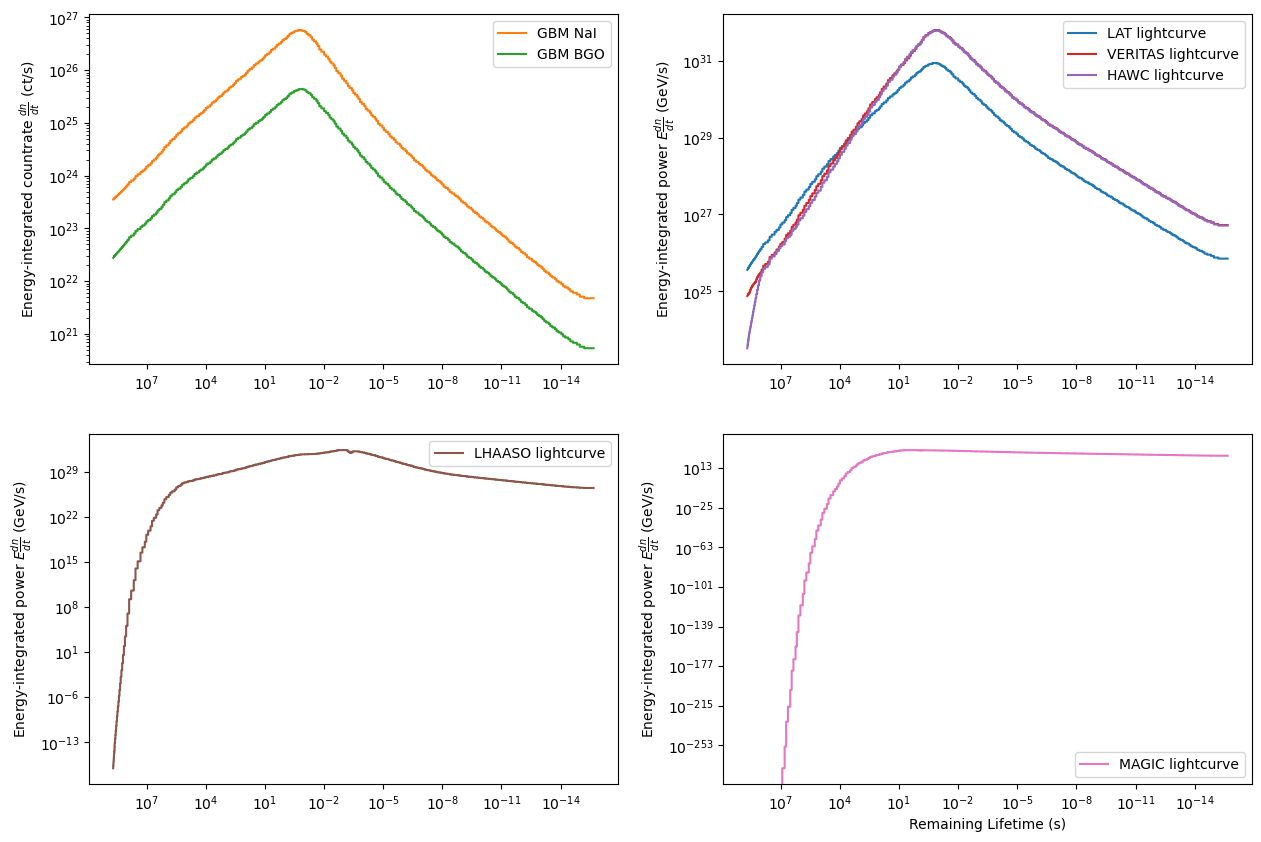

In [212]:
lat_lc = generate_lightcurve(dir, frag, LAT_energy) # Units erg/s
gbm_lc = generate_lightcurve(dir, frag, GBM_energy, LAT=False) # Units counts/s
bgo_lc = generate_lightcurve(dir, frag, BGO_energy, LAT=False) # Units counts/s

ver_lc = generate_lightcurve(dir, frag, telescope_energy_dict['VERITAS_energy']) # Units erg/s
hwc_lc = generate_lightcurve(dir, frag, telescope_energy_dict['HAWC_energy']) # Units erg/s
mag_lc = generate_lightcurve(dir, frag, telescope_energy_dict['MAGIC_energy']) # Units erg/s
lha_lc = generate_lightcurve(dir, frag, telescope_energy_dict['LHAASO_energy']) # Units erg/s

fig, axes = plt.subplots(2,2, figsize = (15,10))
#fig, axes = plt.subplots(1, 2, figsize = (12, 5))
###
# ax2 = ax1.twinx()
# axes = (ax1, ax2)

# ax = axes[0]
axes[0,1].step(time, lat_lc, label = 'LAT lightcurve', color='C0')

axes[0,1].step(time, ver_lc, label = 'VERITAS lightcurve', color='C3')
axes[0,1].step(time, hwc_lc, label = 'HAWC lightcurve', color='C4')
axes[1,0].step(time, lha_lc, label = 'LHAASO lightcurve', color='C5')
axes[1,1].step(time, mag_lc, label = 'MAGIC lightcurve', color='C6')

for ax in axes.flatten()[1:]:
    ax.set_ylabel(r'Energy-integrated power $E\frac{dn}{dt}$ (GeV/s)')
# ax.legend(loc='upper left')

# ax = axes[1]
axes[0,0].step(time, gbm_lc, label = 'GBM NaI', color = 'C1')
axes[0,0].step(time, bgo_lc, label = 'GBM BGO', color = 'C2')
axes[0,0].set_ylabel(r'Energy-integrated countrate $\frac{dn}{dt}$ (ct/s)')


for ax in axes.flatten():
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')

    lims = ax.get_xlim()
    ax.set_xlim(lims[1], lims[0])

ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('Lightcurves.png', dpi=500)


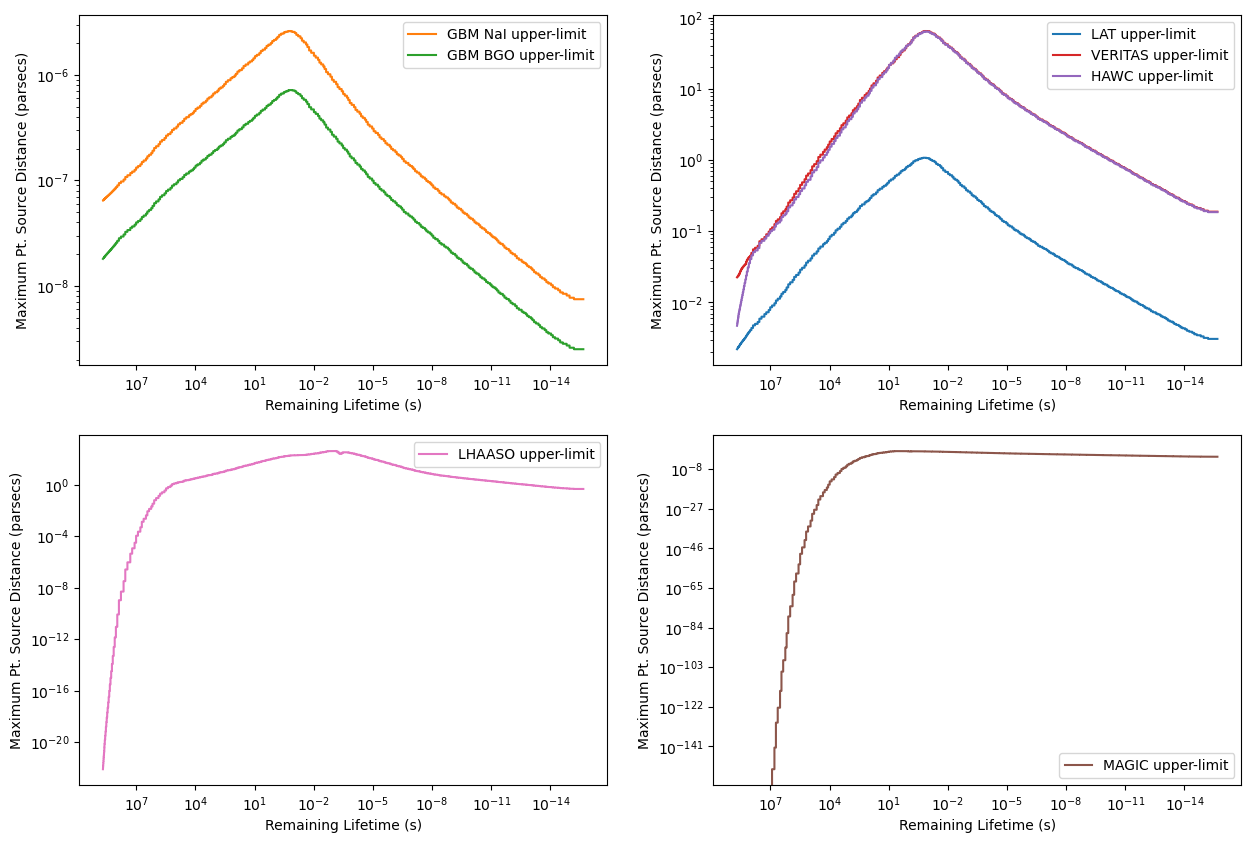

In [216]:
# Diff. Flux Sensitivity of the LAT  E^2 d^2NdEdt
distance_fcn_LAT = lambda f, sens = 1e-10: np.sqrt(f / (sens * u.erg.to('GeV') * 4*3.14159) ) # This sens is ergs and lc is GeV

""" Minimum flux approach
#distance_fcn_GBM = lambda f, time=time, sens=1e-8: [np.sqrt(sens * u.erg.to('GeV') * u.cm**2 * 4*3.14159 / Riemann_Integrate(time[-i:], f[-i:])[0]) for i in range(1,len(time)-1)]
def distance_fcn_GBM(f, time=np.array(time), sens=1e-8): # sens erg/cm^2 (time-integrated diff flux sens)
    arr = []
    for i in range(1,len(time)+1):
        integ = Riemann_Integrate(time[-i:], f[-i:])[0]
        arr.append(np.sqrt(sens * u.erg.to('GeV') * u.cm**2 * 4*3.14159 / integ))
    return arr
 """

# If we expect >0.71 photons/cm^2/s, take flux dN/dt and require (counts/s) / 4pi d^2 (cm^2) > 0.71 (counts/s/cm^2)
# Just redid the GBM lcs to now be in cts/s/cm2
distance_fcn_GBM = lambda f, sens = 0.71: np.sqrt(f / (sens * 4 * 3.14159)) # This sens is unitless

lat_d = (distance_fcn_LAT(lat_lc) * u.cm).to('pc')
gbm_d = (distance_fcn_GBM(gbm_lc) * u.cm).to('pc')
bgo_d = (distance_fcn_GBM(bgo_lc) * u.cm).to('pc')

ver_d = (distance_fcn_LAT(ver_lc, sens = 2e-13) * u.cm).to('pc')
hwc_d = (distance_fcn_LAT(hwc_lc, sens = 2e-13) * u.cm).to('pc')
mag_d = (distance_fcn_LAT(mag_lc, sens = 1e-12) * u.cm).to('pc')
lha_d = (distance_fcn_LAT(lha_lc, sens = 2e-14) * u.cm).to('pc')


fig, axes = plt.subplots(2,2, figsize = (15,10))
#ax = axes[1]
# ax.fill_between(time, gbm_d.value, lat_d.value, alpha = 0.7, label = 'Point sources discernable by LAT only')
# ax.fill_between(time, y1=bgo_d.value, y2=gbm_d.value, alpha = 0.7, label = 'by GBM NaI & LAT')
# ax.fill_between(time, bgo_d.value, alpha=0.5, label = 'by both GBM & LAT')
axes[0,1].step( time, lat_d, color = 'C0', linestyle='-', alpha = 1, label = 'LAT upper-limit')# , '-' , label = 'Max distance for photon detection (LAT)')
axes[0,0].step( time, gbm_d, color = 'C1', linestyle='-', alpha = 1, label = 'GBM NaI upper-limit')# , '-' , label = 'Max distance for photon detection (GBM)')
axes[0,0].step( time, bgo_d, color = 'C2', linestyle='-', alpha = 1, label = 'GBM BGO upper-limit')
axes[0,1].step( time, ver_d, color = 'C3', linestyle='-', alpha = 1, label = 'VERITAS upper-limit')
axes[0,1].step( time, hwc_d, color = 'C4', linestyle='-', alpha = 1, label = 'HAWC upper-limit')
axes[1,1].step( time, mag_d, color = 'C5', linestyle='-', alpha = 1, label = 'MAGIC upper-limit')
axes[1,0].step( time, lha_d, color = 'C6', linestyle='-', alpha = 1, label = 'LHAASO upper-limit')

#ax.axhline(0.015, linestyle='-.', color='darkred', label = '0.015 pc', alpha=0.5)

for ax in axes.flatten():
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')

    lims = ax.get_xlim()
    ax.set_xlim(lims[1], lims[0])

    ax.set_ylabel('Maximum Pt. Source Distance (parsecs)')
    ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('DistFuncs.png', dpi=500)


In [160]:
def calculate_t90(distances, lightcurve, sensitivity = 1e-10 * u.erg.to('GeV'), ratio = 1e-1):
    """
    Input an arbitrary array of distances d & the lightcurve. Determine a cutoff ratio (default 10% total flux).
    Returns an array of T90s corresponding to the distances array

    LAT flags whether sensitivity calculations are provided using LAT (differential sensitivity) or GBM (photon trigger min) methods.

    ALGORITHM:

    We know that the T90 for an EBH is bounded to the right by a sharp cutoff.
    i.e. T95 is virtually = T100

    for each given distance d (arbitrary range)

        Impose a mininum flux cutoff for the fluxes which reach the telescope (according to sensitivity)

        Integrate for the total flux

        Compute the index at which the cumulative flux = 10% total flux (see Riemann_Integrate)

        T90 = remaining time at t break - final time
    """

    t90 = []
    for dist in distances: # All distances corresponding to >1ms of remaining BH lifetime
        
        # Min flux at a given distance to be detected is \phi = sens * 4pi d^2
        minimum_flux = 4 * 3.14159 * dist.to('cm').value**2 * sensitivity # Unit conversion, because below I input an astropy array in parsecs

        # Impose that only fluxes > minimum_flux are included in computation
        interval = np.where(lightcurve > minimum_flux)[0] 

        if interval.shape[0] != 0: # As long as the flux is at all visible.

            # Calculate the total flux across the interval
            total_flux = Riemann_Integrate( x = np.array(time[interval]), \
                y = lightcurve[interval] )[0] # Index 0 is the integral-value
            
            # Integrate again, but this time, stop when flux > 10% of total flux
            i = Riemann_Integrate( x = np.array(time[interval]), \
                y = lightcurve[interval], \
                threshold = ratio*total_flux )[1] # Index 1 is the index-value where 10% total flux is achieved
            
            # The remaining lifetime from the stopping index to the end of the allowed interval is the T90)
            t90.append( time[interval].to_list()[i] - time[interval].to_list()[-1])

        else:
            t90.append(0.) # If flux is invisible, T90 is 0.

    return t90

Time at peak flux: 0.1520


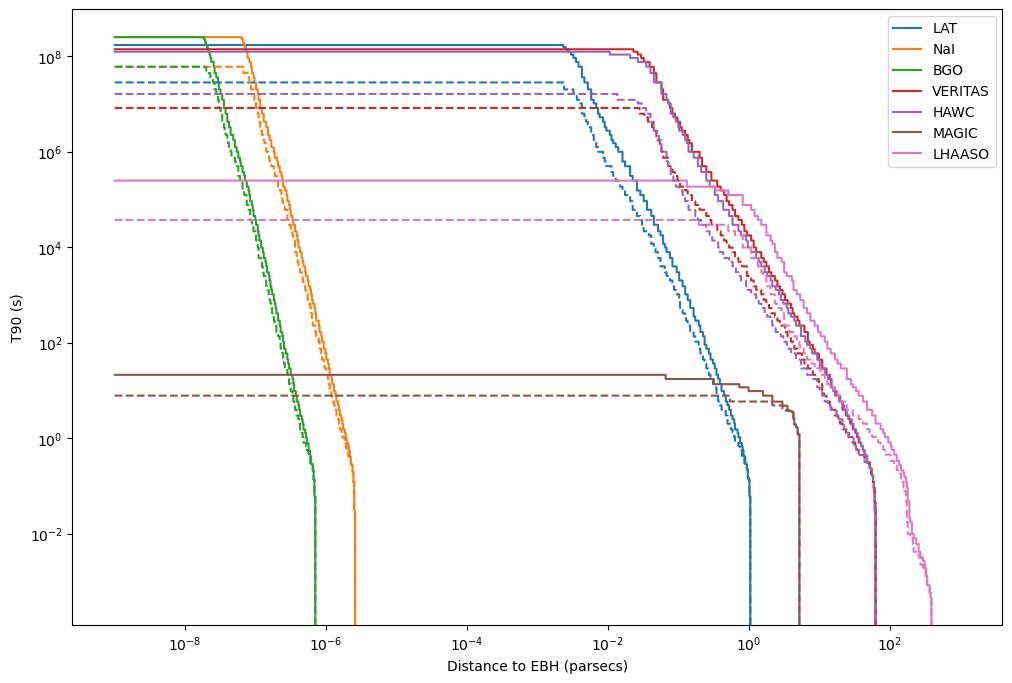

In [221]:
# We have the integrated LAT lightcurves from earlier: lat_lc, gbm_lc (corresponding to NaI) and bgo_lc
fig, ax = plt.subplots(figsize = (12,8))

print('Time at peak flux: %.4f'%time[list(lat_lc).index(lat_lc.max())])

d_range = np.logspace(-9, 3, base = 10, num = 1000)*u.pc
# lat_d_range = lat_d[np.where(time>0.152)]

lat_t90 = calculate_t90(d_range, lat_lc, sensitivity = 1e-10 * u.erg.to('GeV'))

# Do the same for each detector
# gbm_d_range = gbm_d[np.where(time>0.152)] 
gbm_t90 = calculate_t90(d_range, gbm_lc, sensitivity = 0.71)

# bgo_d_range = bgo_d[np.where(time>0.152)]
bgo_t90 = calculate_t90(d_range, bgo_lc, sensitivity = 0.71)

####
ver_t90 = calculate_t90(d_range, ver_lc, sensitivity = 2e-13 * u.erg.to('GeV'))
hwc_t90 = calculate_t90(d_range, hwc_lc, sensitivity = 2e-13 * u.erg.to('GeV'))
mag_t90 = calculate_t90(d_range, mag_lc, sensitivity = 1e-12 * u.erg.to('GeV'))
lha_t90 = calculate_t90(d_range, lha_lc, sensitivity = 2e-14 * u.erg.to('GeV'))

ver_t50 = calculate_t90(d_range, ver_lc, sensitivity = 2e-13 * u.erg.to('GeV'), ratio=.5)
hwc_t50 = calculate_t90(d_range, hwc_lc, sensitivity = 2e-13 * u.erg.to('GeV'), ratio=.5)
mag_t50 = calculate_t90(d_range, mag_lc, sensitivity = 1e-12 * u.erg.to('GeV'), ratio=.5)
lha_t50 = calculate_t90(d_range, lha_lc, sensitivity = 2e-14 * u.erg.to('GeV'), ratio=.5)
###

# Plot
ax.step(d_range, lat_t90, label = 'LAT')
ax.step(d_range, gbm_t90, label = 'NaI')
ax.step(d_range, bgo_t90, label = 'BGO')
#plt.axvline(0.015, color = 'black', linestyle='dashed', alpha=0.5, label = '0.015 pc')

lat_t50 = calculate_t90(d_range, lat_lc, ratio = .5)
gbm_t50 = calculate_t90(d_range, gbm_lc, ratio = .5, sensitivity = 0.71)
bgo_t50 = calculate_t90(d_range, bgo_lc, ratio = .5, sensitivity = 0.71)

ax.step(d_range, lat_t50, linestyle='--', color = 'C0')#, label = 'LAT T50')
ax.step(d_range, gbm_t50, linestyle='--', color = 'C1')#, label = 'GBM T50')
ax.step(d_range, bgo_t50, linestyle='--', color = 'C2')#, label = 'BGO T50')

###
ax.step(d_range, ver_t90, linestyle='-', color = 'C3', label = 'VERITAS')
ax.step(d_range, hwc_t90, linestyle='-', color = 'C4', label = 'HAWC')
ax.step(d_range, mag_t90, linestyle='-', color = 'C5', label = 'MAGIC')
ax.step(d_range, lha_t90, linestyle='-', color = 'C6', label = 'LHAASO')

ax.step(d_range, ver_t50, linestyle='--', color = 'C3')#, label = 'LAT T50')
ax.step(d_range, hwc_t50, linestyle='--', color = 'C4')#, label = 'GBM T50')
ax.step(d_range, mag_t50, linestyle='--', color = 'C5')#, label = 'BGO T50')
ax.step(d_range, lha_t50, linestyle='--', color = 'C6')#, label = 'BGO T50')
###

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

fig.savefig('T90s.png', dpi=500)

In [172]:
d_range[np.where(np.array(lat_t90) == 0.)[0][0]]

<Quantity 1.06912634 pc>

In [177]:
# Min distance of a GRB of T90 100s
d_range[np.where(np.array(lat_t90) <= 60.)[0][0]]

<Quantity 0.2808332 pc>

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


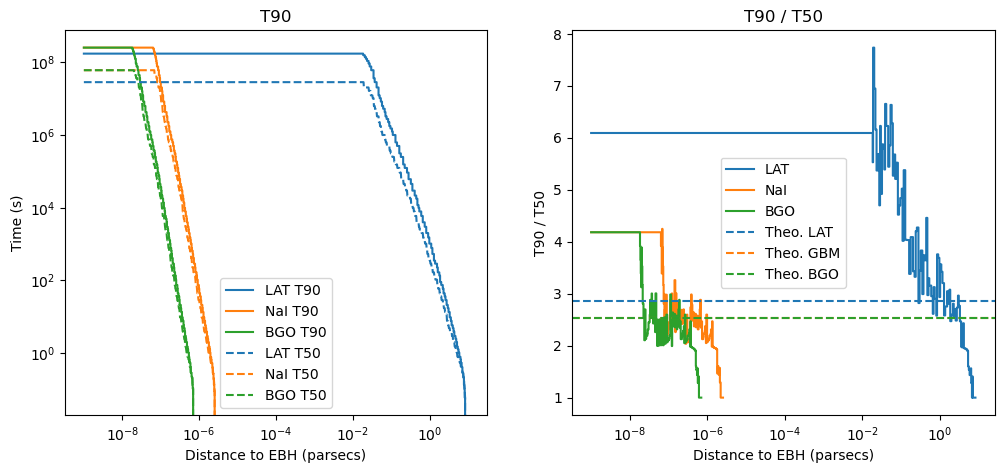

In [123]:
# T90/T50 could be a way to cross-validate with normalization for the distance from the EBH.
# It could also be used as a proxy for index.

lat_t50 = calculate_t90(d_range, lat_lc, ratio = .5)
gbm_t50 = calculate_t90(d_range, gbm_lc, ratio = .5, sensitivity = 0.71)
bgo_t50 = calculate_t90(d_range, bgo_lc, ratio = .5, sensitivity = 0.71)

fig, axes = plt.subplots(1, 2, figsize = (12,5))

ax = axes[0]
ax.step(d_range, lat_t90, label = 'LAT T90')
ax.step(d_range, gbm_t90, label = 'NaI T90')
ax.step(d_range, bgo_t90, label = 'BGO T90')
#plt.axvline(0.015, color = 'black', linestyle='dashed', alpha=0.5, label = '0.015 pc')

ax.plot(d_range, lat_t50, label = 'LAT T50', linestyle='--', color='C0')
ax.plot(d_range, gbm_t50, label = 'NaI T50', linestyle='--', color='C1')
ax.plot(d_range, bgo_t50, label = 'BGO T50', linestyle='--', color='C2')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('Time (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('T90')

ax = axes[1]

lat_tdiv = np.divide(lat_t90, lat_t50)
gbm_tdiv = np.divide(gbm_t90, gbm_t50)
bgo_tdiv = np.divide(bgo_t90, bgo_t50)

ax.step(d_range, lat_tdiv, label = 'LAT')#, avg: %.1f'%lat_tdiv[~np.isnan(lat_tdiv)].mean())
ax.step(d_range, gbm_tdiv, label = 'NaI')#, avg: %.1f'%gbm_tdiv[~np.isnan(gbm_tdiv)].mean())
ax.step(d_range, bgo_tdiv, label = 'BGO')#, avg: %.1f'%bgo_tdiv[~np.isnan(bgo_tdiv)].mean())

ax.axhline(2.857, label = 'Theo. LAT', linestyle = '--', color = 'C0')
ax.axhline(2.538, label = 'Theo. GBM', linestyle = '--', color = 'C1')
ax.axhline(2.535, label = 'Theo. BGO', linestyle = '--', color = 'C2')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 / T50')

ax.legend()
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('T90 / T50')

fig.savefig('TdivRatio.png', dpi=500)

In [124]:
[d.max() for d in [lat_d, gbm_d, bgo_d]]

[<Quantity 1.07549863 pc>,
 <Quantity 1.84794918e-06 pc>,
 <Quantity 5.09666258e-07 pc>]

----------

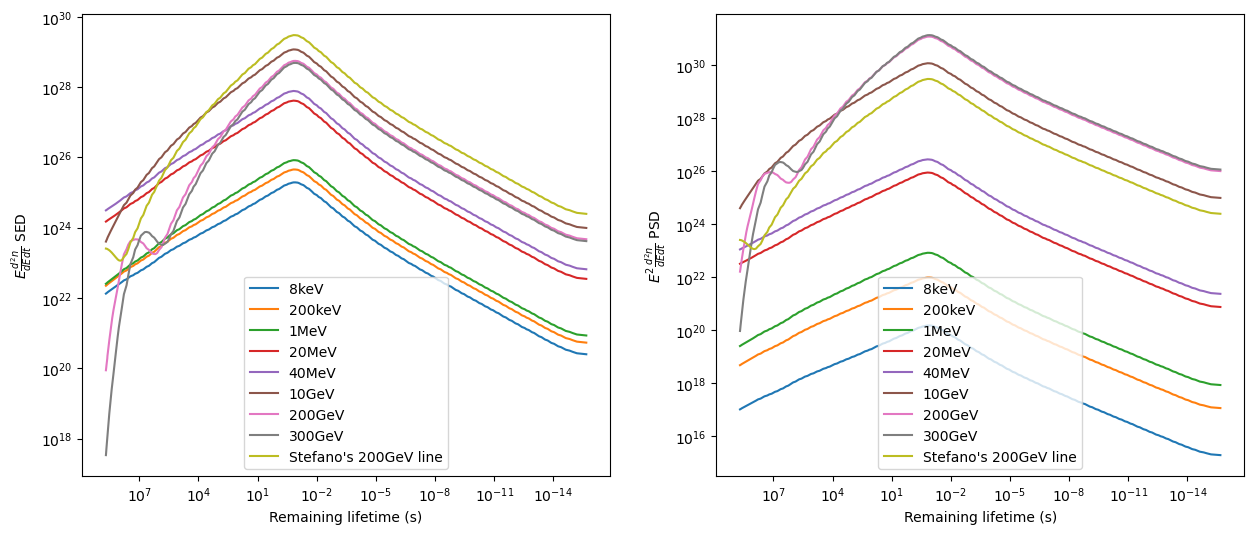

In [125]:
###
# SED approach
###

fig, axes = plt.subplots(1, 2, figsize=(15,6))

ax = axes[0]

energies = {
    '8keV': ('7.05480e-06', '7.74264e-06'),
    '200keV': ('2.00923e-04', '2.15443e-04'),
    '1MeV': ('1.07227e-03', '1.00000e-03'),
    '20MeV': ('1.74753e-02', '2.15443e-02'),
    '40MeV': ('4.03702e-02', '3.59381e-02'),
    '10GeV': ('1.07227e+01', '1.00000e+01'),
    '200GeV': ('1.74753e+02', '2.15443e+02'),
    '300GeV': ('3.05386e+02', '2.78256e+02')
}

flux_curves = {}

for bin in energies:
    Edir, Efrag = energies[bin]
    lc = frag[Efrag] * float(Efrag) + dir[Edir] * float(Edir)
    ax.plot(time, lc, label = bin)
    flux_curves[bin] = lc

ax.plot(time, hardness['EdndE-200GeV'], label = 'Stefano\'s 200GeV line')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$E \frac{d^2n}{dEdt}$ SED')
ax.set_xlabel('Remaining lifetime (s)')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])
ax.legend()

################################################################

ax = axes[1]

power_curves = {}

for bin in energies:
    Edir, Efrag = energies[bin]
    lc = frag[Efrag] * float(Efrag)**2 + dir[Edir] * float(Edir)**2
    ax.plot(time, lc, label = bin)
    power_curves[bin] = lc

ax.plot(time, hardness['EdndE-200GeV'], label = 'Stefano\'s 200GeV line')


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$E^2 \frac{d^2n}{dEdt}$ PSD')
ax.set_xlabel('Remaining lifetime (s)')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])
ax.legend()


TypeError: can't multiply sequence by non-int of type 'float'

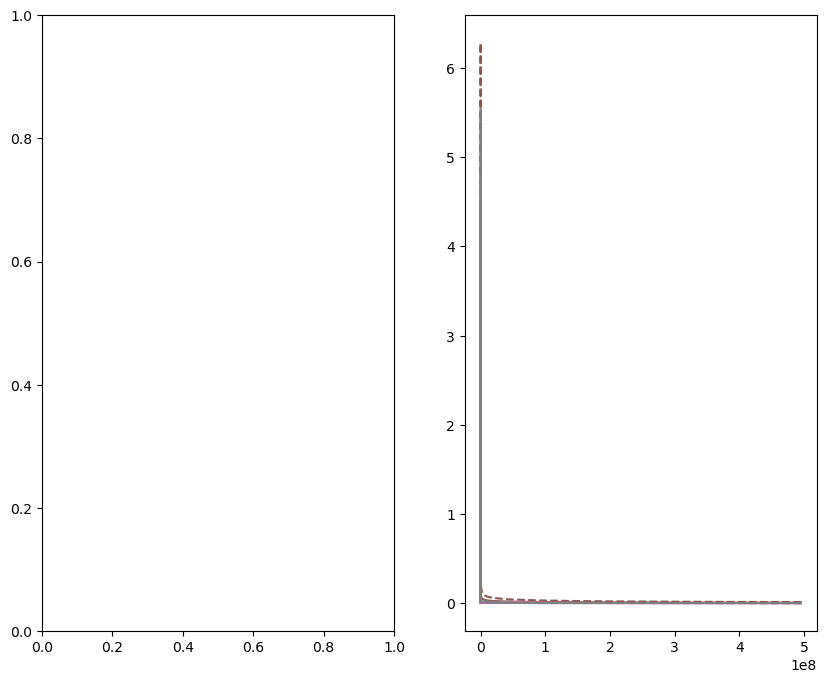

In [132]:
# Using differential flux tables: https://www.slac.stanford.edu/exp/glast/groups/canda/archive/pass8r3v2/lat_Performance.htm
on_axis_flux_sensitivity = {
    '40MeV': 1.90e-11,
    '10GeV': 2.49e-12,
    '200GeV': 9.09e-12,
    '300GeV': 9.09e-12
}

off_axis_flux_sensitivity = {
    '40MeV': 3.35e-12,
    '10GeV': 4.03e-13,
    '200GeV': 6.96e-12,
    '300GeV': 5.96e-12
}

# Function to integrate over
distance_fcn_LAT = lambda f, sens = 1e-10: np.sqrt( (1/ (sens * u.erg.to('GeV')) ) * u.cm.to('pc')**2 * u.s * f / (4*3.14159) )

on_axis_distances = {bin: distance_fcn_LAT(power_curves[bin].to_list(), sens = on_axis_flux_sensitivity[bin]) for bin in on_axis_flux_sensitivity}
off_axis_distances = {bin: distance_fcn_LAT(power_curves[bin].to_list(), sens = off_axis_flux_sensitivity[bin]) for bin in off_axis_flux_sensitivity}

fig, axes = plt.subplots(1,2, figsize=(10,8))

ax = axes[1]
for i,bin in enumerate(on_axis_distances):
    ax.plot(time, on_axis_distances[bin], label = bin, color = 'C%s'%(i+4))
    ax.plot(time, off_axis_distances[bin], linestyle = '--', color = 'C%s'%(i+4))


# For GBM, use the trigger threshold
GBM_trigger_threshold = 0.71 # photons/cm2/s
gbm_distances = {bin: distance_fcn_GBM(flux_curves[bin].to_list(), sens = GBM_trigger_threshold) for bin in ['8keV', '200keV', '1MeV', '20MeV']}

ax = axes[0]
for i, bin in enumerate(gbm_distances):
    ax.plot(time, on_axis_distances[bin], label = bin, color = 'C%s'%i)


for ax in axes:
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylabel('Distance fcn of PSD')
    ax.set_xlabel('Remaining lifetime (s)')

    lims = ax.get_xlim()
    ax.set_xlim(lims[1], lims[0])
    ax.legend()

In [84]:
# This was just to calculate the bin with the largest energy
for bin in frag:#print(bin)
    print('energy: %s max E^2 F(E): %s'%(bin, max((float(bin)**2 * frag[bin]))))

    # Ok so best energy is ~ 12GeV

energy: 1.00000e-06 max E^2 F(E): 1.6750700000000003e+18
energy: 1.29155e-06 max E^2 F(E): 4.2748935072288246e+18
energy: 1.66810e-06 max E^2 F(E): 9.772370151896099e+18
energy: 2.15443e-06 max E^2 F(E): 2.011586218502287e+19
energy: 2.78256e-06 max E^2 F(E): 3.364719131549952e+19
energy: 3.59381e-06 max E^2 F(E): 5.183339871019782e+19
energy: 4.64159e-06 max E^2 F(E): 7.393140253617068e+19
energy: 5.99484e-06 max E^2 F(E): 1.0572272207119008e+20
energy: 7.74264e-06 max E^2 F(E): 1.510132038569309e+20
energy: 1.00000e-05 max E^2 F(E): 2.1329500000000007e+20
energy: 1.29155e-05 max E^2 F(E): 2.954507842079951e+20
energy: 1.66810e-05 max E^2 F(E): 4.1460943156282996e+20
energy: 2.15443e-05 max E^2 F(E): 5.7542454556610285e+20
energy: 2.78256e-05 max E^2 F(E): 8.070308684900353e+20
energy: 3.59381e-05 max E^2 F(E): 1.09652342983689e+21
energy: 4.64159e-05 max E^2 F(E): 1.5265664011042087e+21
energy: 5.99484e-05 max E^2 F(E): 2.0653737692052193e+21
energy: 7.74264e-05 max E^2 F(E): 2.83619

TypeError: can't multiply sequence by non-int of type 'float'

In [16]:
# Now we want to calculate TIME( DISTANCE ) for MINIMUM_FLUX is exceeded

minimum_fluence = 1e-8 * u.erg.to('GeV')#* u.Eerg.to('GeV')

d = np.logspace(-3, 1) * u.pc.to('cm')


T100 = {bin: [] for bin in lightcurves}
T90 = {bin: [] for bin in lightcurves}
T50 = {bin: [] for bin in lightcurves}


for bin in lightcurves:
    for distance in d:

        total_fluence, _ = Riemann_Integrate(time, lightcurves[bin].to_list())

        _, i = Riemann_Integrate(time, lightcurves[bin].to_list(), threshold = minimum_fluence * 4 * 3.14159 * distance**2)
        T100[bin].append(time[i])
        
        _, i = Riemann_Integrate(time, lightcurves[bin].to_list(), threshold = 0.9 * minimum_fluence * 4 * 3.14159 * distance**2)
        T50[bin].append(time[i])
        
        _, i = Riemann_Integrate(time, lightcurves[bin].to_list(), threshold = 0.5 * minimum_fluence * 4 * 3.14159 * distance**2)
        T90[bin].append(time[i])


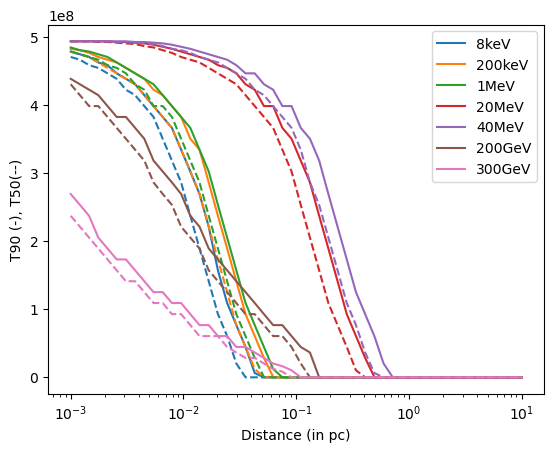

In [17]:
for i,bin in (enumerate(lightcurves)):
    plt.plot(d * u.cm.to('pc'), T90[bin], label = bin, color = 'C%s'%i)
    plt.plot(d * u.cm.to('pc'), T50[bin], color = 'C%s'%i, linestyle = '--')

plt.xlabel('Distance (in pc)')
plt.ylabel('T90 (-), T50(--)')
plt.xscale('log')
plt.legend()

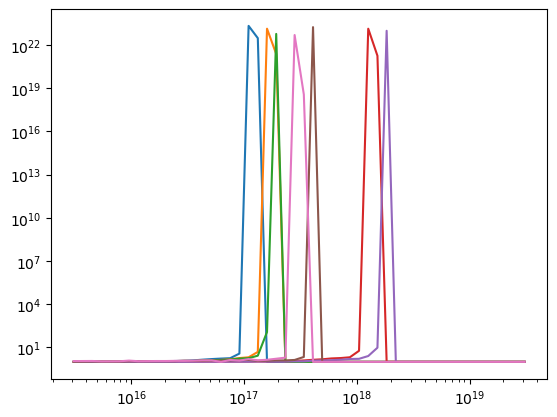

In [18]:
T9050 = {bin: np.array(T90[bin])/np.array(T50[bin]) for bin in lightcurves}

for bin in lightcurves:
    plt.loglog(d, T9050[bin], label = 'bin')

[Hardness](#hd)

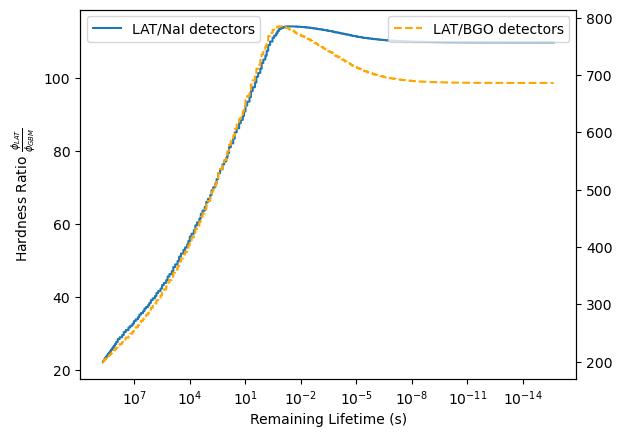

In [9]:
fig, ax = plt.subplots()

ax.step(time, np.divide(lat_lc,gbm_lc), label = 'LAT/NaI detectors')
ax2 = ax.twinx()
ax2.step(time, np.divide(lat_lc,bgo_lc), label = 'LAT/BGO detectors', color = 'orange', linestyle='--')

ax.set_xscale('log')
#ax.set_yscale('log')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.legend()
ax2.legend()
ax.set_ylabel(r'Hardness Ratio $\frac{\phi_{LAT}}{\phi_{GBM}}$')
ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('Hardness.png', dpi = 500)

[Finding T90s](#T90)

In [11]:
# Point source sensitivity
sens = 10**-9 /u.s /u.cm**2

# Note also that the "time" variable is a global variable = your "Time to Death" array from Mathematica

lat_d = d(lat_lc/u.s).to('pc')
gbm_d = d(gbm_lc/u.s).to('pc')
bgo_d = d(bgo_lc/u.s).to('pc')

def calculate_t90(distances, lightcurve, ratio = 1e-1):
    """
    Input an arbitrary array of distances d & the lightcurve. Determine a cutoff ratio (default 10% total flux).
    Returns an array of T90s corresponding to the distances array


    ALGORITHM:

    We know that the T90 for an EBH is bounded to the right by a sharp cutoff.
    i.e. T95 is virtually = T100

    for each given distance d (arbitrary range)

        Impose a mininum flux cutoff for the fluxes which reach the telescope (according to sensitivity)

        Integrate for the total flux

        Compute the index at which the cumulative flux = 10% total flux (see Riemann_Integrate)

        T90 = remaining time at t break - final time
    """

    t90 = []
    for dist in distances: # All distances corresponding to >1ms of remaining BH lifetime
        
        # Min flux at a given distance to be detected is \phi = sens * 4pi d^2
        minimum_flux = 4 * 3.14159 * dist.to('cm').value**2 * sens.value # Unit conversion, because below I input an astropy array in parsecs

        # Impose that only fluxes > minimum_flux are included in computation
        interval = np.where(lightcurve > minimum_flux)[0] 

        if interval.shape[0] != 0: # As long as the flux is at all visible.

            # Calculat the total flux across the interval
            total_flux = Riemann_Integrate( x = np.array(time[interval]), \
                y = lightcurve[interval] )[0] # Index 0 is the integral-value
            
            # Integrate again, but this time, stop when flux > 10% of total flux
            i = Riemann_Integrate( x = np.array(time[interval]), \
                y = lightcurve[interval], \
                threshold = ratio*total_flux )[1] # Index 1 is the index-value where 10% total flux is achieved
            
            # The remaining lifetime from the stopping index to the end of the allowed interval is the T90)
            t90.append( time[interval].to_list()[i] - time[interval].to_list()[-1])

        else:
            t90.append(0.) # If flux is invisible, T90 is 0.

    return t90

Time at peak flux: 0.1520


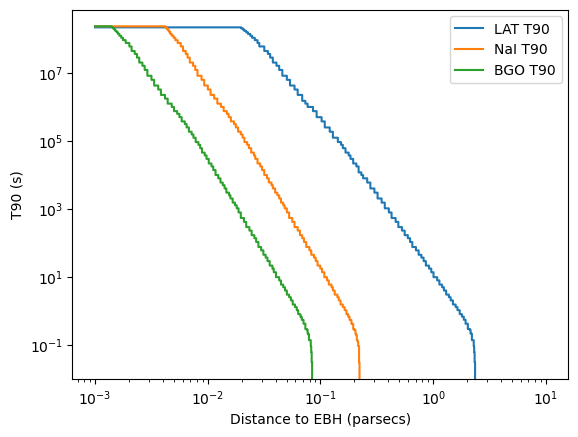

In [12]:
# We have the integrated LAT lightcurves from earlier: lat_lc, gbm_lc (corresponding to NaI) and bgo_lc

print('Time at peak flux: %.4f'%time[list(lat_lc).index(lat_lc.max())])

d_range = np.logspace(-3, 1, base = 10, num = 1000)*u.pc
# lat_d_range = lat_d[np.where(time>0.152)]

lat_t90 = calculate_t90(d_range, lat_lc)

# Do the same for each detector
# gbm_d_range = gbm_d[np.where(time>0.152)] 
gbm_t90 = calculate_t90(d_range, gbm_lc)

# bgo_d_range = bgo_d[np.where(time>0.152)]
bgo_t90 = calculate_t90(d_range, bgo_lc)

# Plot
fig, ax = plt.subplots()
ax.step(d_range, lat_t90, label = 'LAT T90')
ax.step(d_range, gbm_t90, label = 'NaI T90')
ax.step(d_range, bgo_t90, label = 'BGO T90')
#plt.axvline(0.015, color = 'black', linestyle='dashed', alpha=0.5, label = '0.015 pc')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

fig.savefig('T90s.png', dpi=500)

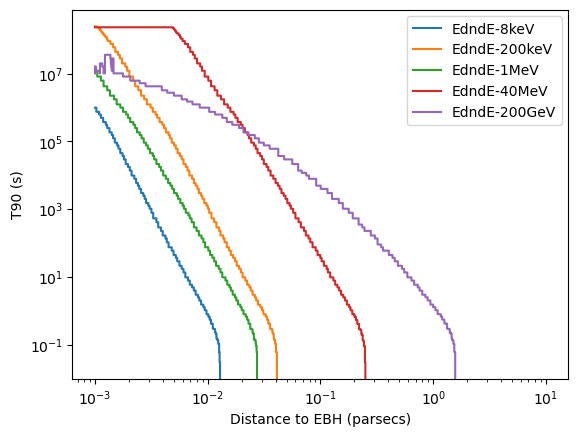

In [13]:
# BONUS: here's the same T90 calculation on your SED curves

fig, ax = plt.subplots()

for energy_bin in ['EdndE-8keV', 'EdndE-200keV', 'EdndE-1MeV', 'EdndE-40MeV', 'EdndE-200GeV']:

    d_range = np.logspace(-3, 1, base = 10, num = 1000)*u.pc
    t90 = calculate_t90(
        d_range, np.array(hardness[energy_bin])
    )
    ax.step(d_range, t90, label = energy_bin)

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

T90/T50 could be a good proxy for the index.

We model the Blackhawk lightcurve with a powerlaw.
For remaining lifetime $\tau = t$, the flux is modelled by a powerlaw with an index $|i|$: $F(t) = t^{-i}$

Allow $t_d$ to be the instant at which the minimum flux is met \& the photon lightcurve becomes observable (== the T0). 

Total Flux = $\int_{t_d}^0 t^{-i}dt = \frac{t^{1-i}}{1-i}|_{t_d}^0$

The T90 is determined by the relationship:
$$\int_{T90}^0 t^{-i} = 0.9 \times \int_{t_d}^0 t^{-i}$$
$$T90 = 0.9^{\frac{1}{1-i}}t_d$$

Similarly, the T50 is:
$$T50 =  0.5^{\frac{1}{1-i}}t_d$$

Such that
$$\frac{T90}{T50} = (\frac{9}{5})^{\frac{1}{1-i}}$$ 

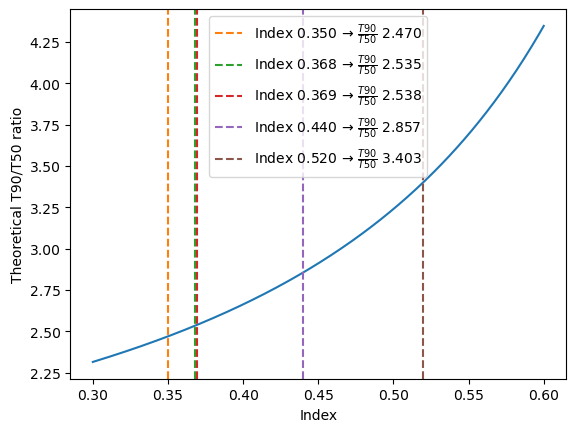

In [15]:
fig, ax = plt.subplots()

indices = np.linspace(0.3, 0.6, 301)
Tdiv = lambda index: (9/5)**(1/(1-index))
ax.plot(indices, Tdiv(indices))
ax.set_xlabel('Index')
ax.set_ylabel('Theoretical T90/T50 ratio')

# This ends up being somewhat consistent with the experimental results below.

for c,i in enumerate([.35, .368, .369, .44, .52]):
    ax.axvline(i, linestyle='--', label = r'Index %.3f $\to$ $\frac{T90}{T50}$ %.3f'%(i, \
        Tdiv(indices)[ \
            list(indices).index(i) \
            ]),
        color = 'C%s'%(c+1))

ax.legend()

fig.savefig('TheoreticalTdivRatio.png', dpi=500)

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


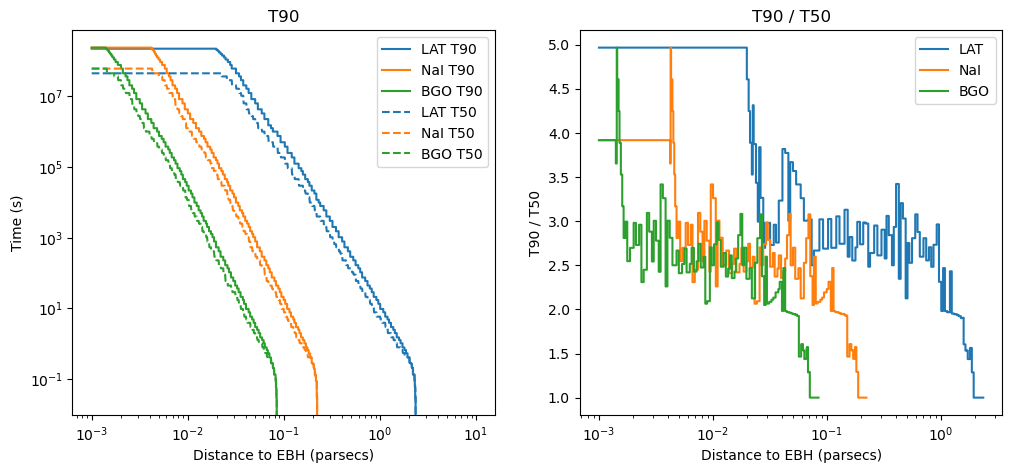

In [15]:
# T90/T50 could be a way to cross-validate with normalization for the distance from the EBH.
# It could also be used as a proxy for index.

lat_t50 = calculate_t90(d_range, lat_lc, ratio = .5)
gbm_t50 = calculate_t90(d_range, gbm_lc, ratio = .5)
bgo_t50 = calculate_t90(d_range, bgo_lc, ratio = .5)

fig, axes = plt.subplots(1, 2, figsize = (12,5))

ax = axes[0]
ax.step(d_range, lat_t90, label = 'LAT T90')
ax.step(d_range, gbm_t90, label = 'NaI T90')
ax.step(d_range, bgo_t90, label = 'BGO T90')
#plt.axvline(0.015, color = 'black', linestyle='dashed', alpha=0.5, label = '0.015 pc')

ax.plot(d_range, lat_t50, label = 'LAT T50', linestyle='--', color='C0')
ax.plot(d_range, gbm_t50, label = 'NaI T50', linestyle='--', color='C1')
ax.plot(d_range, bgo_t50, label = 'BGO T50', linestyle='--', color='C2')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('Time (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('T90')

ax = axes[1]

lat_tdiv = np.divide(lat_t90, lat_t50)
gbm_tdiv = np.divide(gbm_t90, gbm_t50)
bgo_tdiv = np.divide(bgo_t90, bgo_t50)

ax.step(d_range, lat_tdiv, label = 'LAT')#, avg: %.1f'%lat_tdiv[~np.isnan(lat_tdiv)].mean())
ax.step(d_range, gbm_tdiv, label = 'NaI')#, avg: %.1f'%gbm_tdiv[~np.isnan(gbm_tdiv)].mean())
ax.step(d_range, bgo_tdiv, label = 'BGO')#, avg: %.1f'%bgo_tdiv[~np.isnan(bgo_tdiv)].mean())

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 / T50')

ax.legend()
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('T90 / T50')

fig.savefig('TdivRatio.png', dpi=500)

In [334]:
# fig, axes = plt.subplots(1,2, figsize = (12,6))

# ax = axes[0]
# ax.step(lat_d_range, (lat_lc.max()/(4*3.14159*lat_d_range**2)), label = 'LAT')
# ax.step(gbm_d_range, (gbm_lc.max()/(4*3.14159*gbm_d_range**2)), label = 'NaI')
# ax.step(bgo_d_range, (bgo_lc.max()/(4*3.14159*bgo_d_range**2)), label = 'BGO')

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlabel('Distances (parsecs)')
# ax.set_ylabel('Peak flux (/s)')

# ax = axes[1]
# ax.step(lat_d_range, lat_t90*(lat_lc.max()/(4*3.14159*lat_d_range**2)), label = 'LAT')
# ax.step(gbm_d_range, gbm_t90*(gbm_lc.max()/(4*3.14159*gbm_d_range**2)), label = 'NaI')
# ax.step(bgo_d_range, bgo_t90*(bgo_lc.max()/(4*3.14159*bgo_d_range**2)), label = 'BGO')

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlabel('Distances (parsecs)')
# ax.set_ylabel(r'Peak Flux*T90 (unitless)')#($s^{2}$)')

[Calculating energy spectrum](#es)

In [335]:
# spectrum_dir = {}
# for energy in dir.columns:
#     # time-interate dir
#     spectrum_dir[energy] =  I.simps(y = dir[energy].astype('float64').to_list(), x = dir.index.astype('float64')) 

# spectrum_frag = {}
# for energy in frag.columns:
#     spectrum_frag[energy] = I.simps(y = frag[energy].to_list(), x = frag.index) 

[Fitting Lightcurves](#lc)

In [23]:
from scipy.optimize import curve_fit

plaw = lambda x,N,index,offset,interc: N*((x-offset)**index) + interc

lat_lc = generate_lightcurve(dir, frag, LAT_energy)
gbm_lc = generate_lightcurve(dir, frag, GBM_energy)
bgo_lc = generate_lightcurve(dir, frag, BGO_energy)

                   Norm         Index        Offset     Intercept
Norm       8.197643e+49 -7.775861e+21 -3.148443e+22  4.420191e+47
Index     -7.775861e+21  1.273726e-06  3.478087e-06 -1.768144e+20
Offset    -3.148443e+22  3.478087e-06  1.378432e-05 -3.602823e+20
Intercept  4.420191e+47 -1.768144e+20 -3.602823e+20  3.181926e+47
                   Norm         Index        Offset     Intercept
Norm       1.483394e+48 -1.002722e+21 -3.927962e+21  7.673103e+45
Index     -1.002722e+21  1.191200e-06  3.127815e-06 -2.322915e+19
Offset    -3.927962e+21  3.127815e-06  1.191295e-05 -4.541993e+19
Intercept  7.673103e+45 -2.322915e+19 -4.541993e+19  5.994615e+45
                   Norm         Index        Offset     Intercept
Norm       1.381298e+54 -1.446432e+24 -4.459560e+24  3.727510e+51
Index     -1.446432e+24  2.481743e-06  5.397282e-06 -2.033341e+22
Offset    -4.459560e+24  5.397282e-06  1.596681e-05 -3.124052e+22
Intercept  3.727510e+51 -2.033341e+22 -3.124052e+22  3.937742e+51


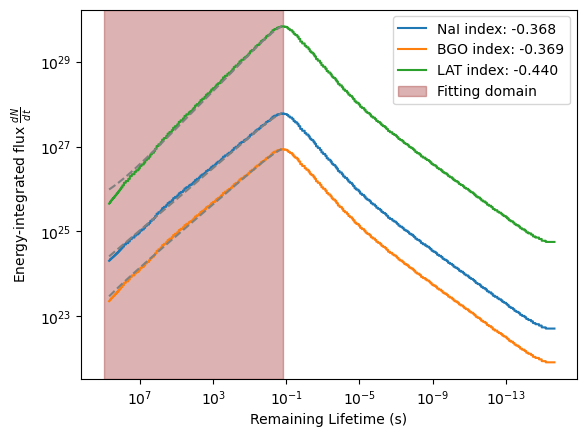

In [32]:
time_max = 1e9
cols = ['Norm', 'Index', 'Offset', 'Intercept']

fig, ax = plt.subplots()

### GBM NaI
filter = np.where(time[:list(gbm_lc).index(gbm_lc.max())] < time_max)[0]
ydata = gbm_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))
   
print( pd.DataFrame(cov, columns = cols, index = cols) )

ax.step(time, gbm_lc, label = 'NaI index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

### GBM BGO
filter = np.where(time[:list(bgo_lc).index(bgo_lc.max())] < time_max)[0]
ydata = bgo_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

print( pd.DataFrame(cov, columns = cols, index = cols) )

ax.step(time, bgo_lc, label = 'BGO index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

### LAT
filter = np.where(time[:list(lat_lc).index(lat_lc.max())] < time_max)[0]
ydata = lat_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))
   
print( pd.DataFrame(cov, columns = cols, index = cols) )

ax.step(time, lat_lc, label = 'LAT index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')


ax.axvspan(time[list(lat_lc).index(lat_lc.max())], time_max, color = 'darkred', alpha = .3, label = 'Fitting domain')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])


ax.set_ylabel(r'Energy-integrated flux $\frac{dN}{dt}$')
ax.set_xlabel('Remaining Lifetime (s)')

fig.savefig('FitPowerlaw_ranges.png',dpi=500)

----


EdndE-8keV
                   Norm         Index        Offset     Intercept
Norm       5.221624e+45 -1.509720e+20 -5.753813e+20  5.031162e+43
Index     -1.509720e+20  1.507921e-05  3.103677e-05 -7.177424e+19
Offset    -5.753813e+20  3.103677e-05  9.034480e-05 -1.134076e+20
Intercept  5.031162e+43 -7.177424e+19 -1.134076e+20  6.784054e+44

EdndE-200keV
                   Norm         Index        Offset     Intercept
Norm       5.936380e+47 -1.652398e+21 -6.598655e+21  7.182185e+45
Index     -1.652398e+21  1.584337e-05  3.399462e-05 -8.017633e+20
Offset    -6.598655e+21  3.399462e-05  1.049196e-04 -1.321535e+21
Intercept  7.182185e+45 -8.017633e+20 -1.321535e+21  7.867501e+46

EdndE-1MeV
                   Norm         Index        Offset     Intercept
Norm       1.120057e+47 -7.291291e+20 -2.862323e+21  2.469981e+45
Index     -7.291291e+20  1.424906e-05  3.155111e-05 -3.022909e+20
Offset    -2.862323e+21  3.155111e-05  9.951461e-05 -5.131841e+20
Intercept  2.469981e+45 -3.022909e+20 

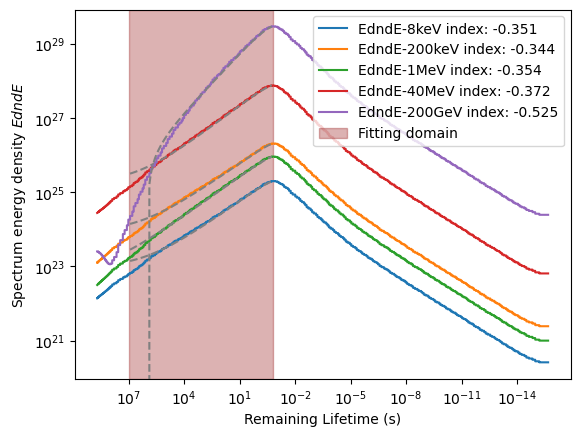

In [33]:
time_max = 1e7

fig, ax = plt.subplots()

for energy_bin in ['EdndE-8keV', 'EdndE-200keV', 'EdndE-1MeV', 'EdndE-40MeV', 'EdndE-200GeV']:
    lc = hardness[energy_bin]
    filter = np.where(time[:list(lc).index(lc.max())] < time_max)[0]
    ydata = lc[filter]
    xdata = time[filter]
    
    params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
    p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

    print('\n%s'%energy_bin)
    print( pd.DataFrame(cov, columns = cols, index = cols) )


    ax.step(time, hardness[energy_bin], label = '%s index: %.3f'%(energy_bin,params[1]))
    ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

ax.axvspan(time[list(lat_lc).index(lat_lc.max())], time_max, color = 'darkred', alpha = .3, label = 'Fitting domain')

# ax.step(hardness['Time to Death'], hardness['EdndE-8keV'], label = '8keV')
# ax.step(hardness['Time to Death'], hardness['EdndE-200keV'], label = '200keV')
# ax.step(hardness['Time to Death'], hardness['EdndE-1MeV'], label = '1MeV')
# ax.step(hardness['Time to Death'], hardness['EdndE-40MeV'], label = '40MeV')
# ax.step(hardness['Time to Death'], hardness['EdndE-200GeV'], label = '200GeV')

#plt.xlim(1e5,1e-3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.set_ylabel(r'Spectrum energy density $EdndE$')
ax.set_xlabel('Remaining Lifetime (s)')

fig.savefig('FitPowerlaw_energies.png',dpi=500)